# Requirement 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bidding_environment import SecondPriceAuction 
from clairvoyant_bidder import get_clairvoyant_truthful
from bidding_agent import MultiplicativePacingAgent,ucblike
from pricing_agent import GPUCBAgent
from pricing_environment import PricingEnvironment,get_expected_profit

## PRICING

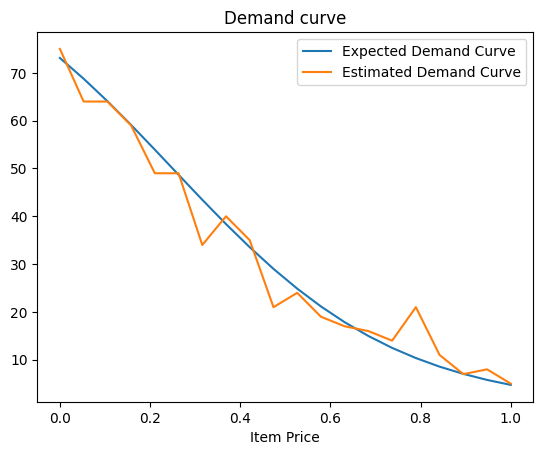

In [2]:
n_cust=100
discretization=20
norm_dem_curve=lambda p: 1-1/(1+np.exp(-4*(p)+1))
y=norm_dem_curve
prices=np.linspace(0,1,discretization)
estimated_demand_curve = np.random.binomial(n_cust, norm_dem_curve(prices))

plt.figure()
plt.title('Demand curve')
plt.plot(prices, n_cust*norm_dem_curve(prices), label='Expected Demand Curve')
plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve')
plt.xlabel('Item Price')
plt.legend()
plt.show()

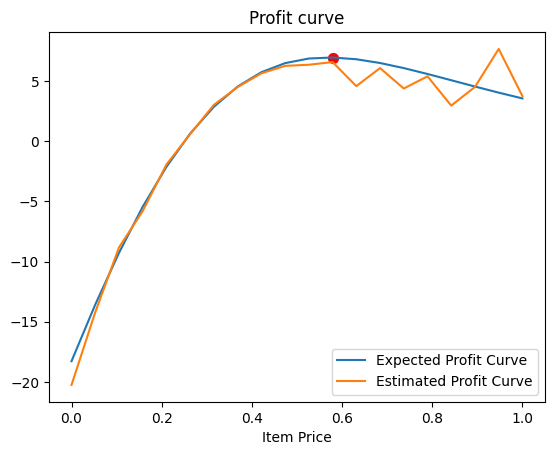

In [3]:
cost = 0.25

expected_profit_curve = n_cust*norm_dem_curve(prices)*(prices-cost)

estimated_profit_curve = np.random.binomial(100,norm_dem_curve(prices))*(prices-cost)

best_price_index = np.argmax(expected_profit_curve)
best_price = prices[best_price_index]

plt.figure()
plt.title('Profit curve')
plt.plot(prices, expected_profit_curve, label='Expected Profit Curve')
plt.plot(prices, estimated_profit_curve, label='Estimated Profit Curve')
plt.scatter(best_price, expected_profit_curve[best_price_index], color='red', s=50)
plt.xlabel('Item Price')
plt.legend()
plt.show()

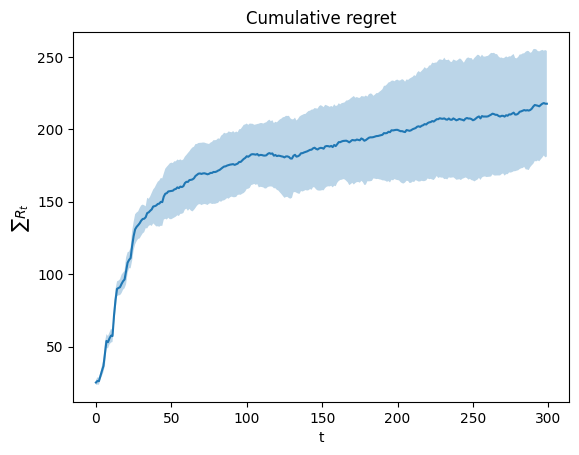

In [4]:
T=300
num_cust=100
all_pulls=[]
all_rewards=[]
all_regrets=[]
epochs=10

for _ in range(epochs):
    pulls=np.array([])
    rewards=np.array([])
    clair_reward=np.array([])
    env=PricingEnvironment(norm_dem_curve,cost)
    agent=GPUCBAgent(T)

    for t in range(T):
        p_t = agent.pull_arm()
        d_t, r_t = env.round(p_t, num_cust)
        agent.update(r_t/num_cust)
        rewards = np.append(rewards, r_t)
        pulls=np.append(pulls,p_t)
        dc,rc=env.round(best_price,num_cust)
        clair_reward = np.append(clair_reward, rc)
    cum_clair_reward=np.cumsum(clair_reward)
    cum_reward=np.cumsum(rewards)
    all_pulls.append(pulls)
    all_rewards.append(rewards)
    all_regrets.append(cum_clair_reward-cum_reward)


    
cum_clair_reward=np.cumsum(clair_reward)
cum_reward=np.cumsum(rewards)
avg_regret=np.mean(np.array(all_regrets),axis=0)
std_regret=np.std(np.array(all_regrets),axis=0)

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('t')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative regret')
plt.show()

Everything looks as expected

## BIDDING

MULTIPLICATIVE PACING

In [56]:
n_advertisers = 15
n_users = 2000
B = 500
my_valuation = 0.75
rho = B/n_users
eta = 1/np.sqrt(n_users)  #theorical learning rate to achieve sub linear regret
ctrs = np.ones(n_advertisers)
discretization=20


n_epochs = 10
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = MultiplicativePacingAgent(valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

    auction = SecondPriceAuction(ctrs)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    #other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users)) # n_advertiser-1 cause one is my agent, that i don't have to consider in other
    other_bids = np.clip(np.random.normal(0.4, 0.2, size = (n_advertisers-1, n_users)), 0, 1)

    m_t = other_bids.max(axis=0)


    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)   
    
    np.random.seed(i)
    for u in range(n_users):

        
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        
    all_regrets.append(np.cumsum(clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis = 0)
std_regret  = np.array(all_regrets).std(axis = 0)


avg_payments = np.array(all_payments).mean(axis = 0)
std_payments = np.array(all_payments).std(axis = 0)

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\danie\AppData\Local\Temp\ipykernel_23972\2560113897.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\danie\AppData\Local\Temp\ipykernel_23972\2560113897.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


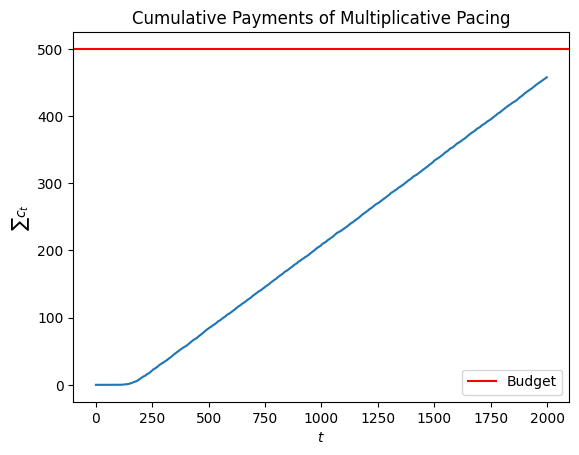

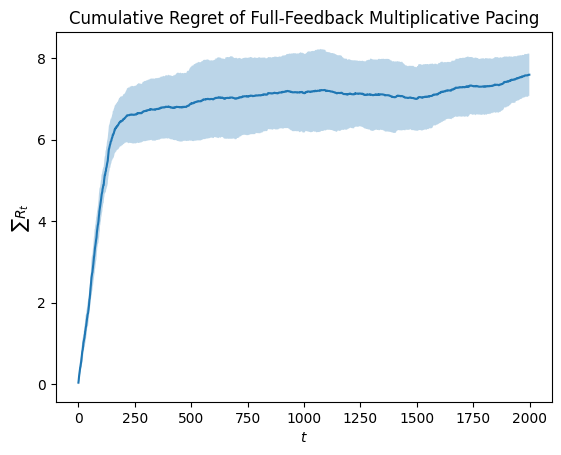

In [58]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

The agent is close to depleting the budget even for different initial values. Everything looks as expected

UCBLIKE

In [61]:
n_advertisers = 15
n_users = 2000
B = 500
my_valuation = 0.75
rho = B/n_users
eta = 1/np.sqrt(n_users)  #theorical learning rate to achieve sub linear regret
ctrs = np.ones(n_advertisers)
discretization=20



n_epochs = 10
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = ucblike(B,n_users,1,my_valuation,discretization=discretization, range=0.1)

    auction = SecondPriceAuction(ctrs)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    #other_bids = np.random.uniform(0, 1, size = (n_advertisers-1, n_users)) # n_advertiser-1 cause one is my agent, that i don't have to consider in other
    other_bids = np.clip(np.random.normal(0.4, 0.2, size = (n_advertisers-1, n_users)), 0, 1)

    m_t = other_bids.max(axis=0)


    clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)   
    
    np.random.seed(i)
    for u in range(n_users):

        
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        
    all_regrets.append(np.cumsum(clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis = 0)
std_regret  = np.array(all_regrets).std(axis = 0)


avg_payments = np.array(all_payments).mean(axis = 0)
std_payments = np.array(all_payments).std(axis = 0)

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\danie\AppData\Local\Temp\ipykernel_23972\3412241667.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\danie\AppData\Local\Temp\ipykernel_23972\3412241667.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


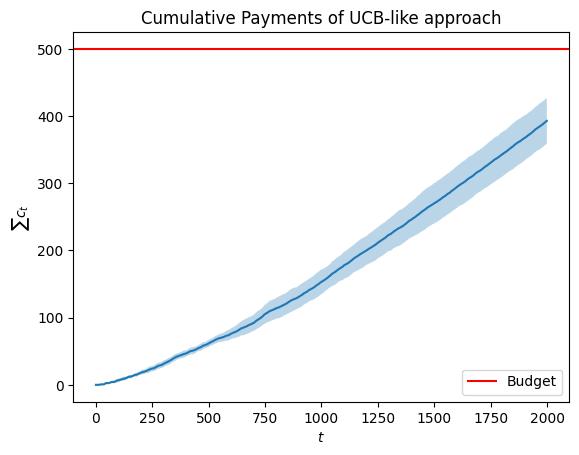

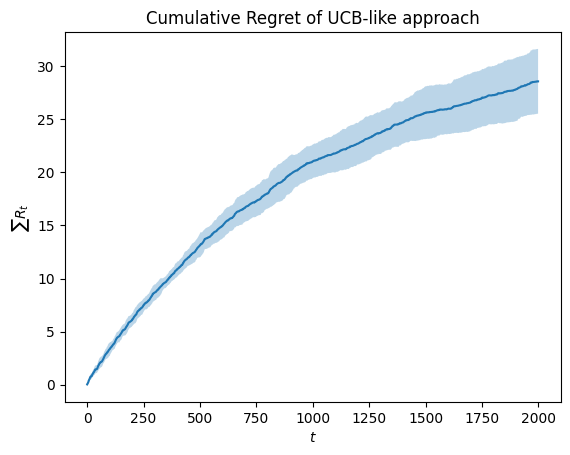

In [62]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB-like approach')
plt.show()

plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB-like approach')
plt.show()

The regret is sublinear, but is worse than multiplicative pacing. For every round, if we win the auction we pay the same amount regardless of our bid (since the environment is a second price auction). The agent is designed for general auction, so It works also for second price auctions, but the performance is worse than what we can achieve with a more "specialized" agent 

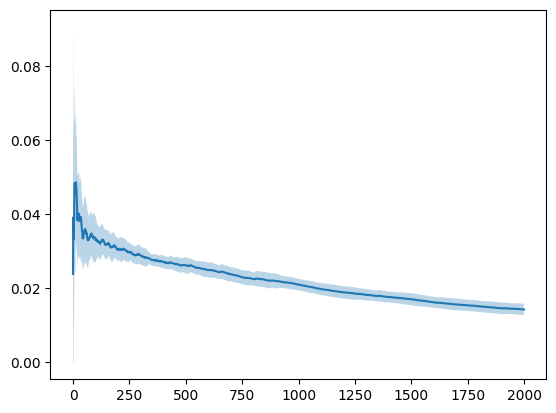

In [63]:
ics = avg_regret/(np.arange(n_users)+1)
ics_spread_plus= (avg_regret + std_regret)/(np.arange(n_users)+1)
ics_spread_minus= np.clip((avg_regret - std_regret)/(np.arange(n_users)+1), 0,1)
plt.plot(np.arange(n_users), ics)
plt.fill_between(np.arange(n_users), ics_spread_minus, ics_spread_plus, alpha=0.3)

### Putting all pieces together: multiplicative pacing

In [12]:
#parameters
days=200
n_users = 100
n_advertisers = 15 # four advertisers, including myself
ctrs = np.ones(n_advertisers)
B = 6000
my_valuation=0.75
profitcurve=lambda price,n_cust: n_cust*norm_dem_curve(price)*(price-cost)

#logging
profits=np.array([])
clair_profits=np.array([])
utility_log=np.zeros(days)
clair_utility=np.zeros(days)
pricing_profit=np.zeros(days)
expected__pricing_pseudo_regret=np.zeros(days)

cumtot_cost = np.array([])


# competitors
other_bids = np.clip(np.random.normal(0.4, 0.2, size = (n_advertisers-1, n_users*days)), 0, 1)
m_t = other_bids.max(axis=0)
## I'm considering competitors stronger than me, since they are free to exceed my budget

# In stochastic enviroment a greedy clairvoyant 
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users*days)

eta = 1/np.sqrt(n_users) # from theory

#agents,envs
bidding_agent = MultiplicativePacingAgent(valuation=my_valuation,budget=B,T=n_users*days,eta=eta)
#bidding_agent = ucblike(B,n_users,1,my_valuation)

auction = SecondPriceAuction(ctrs)
pricing_env=PricingEnvironment(norm_dem_curve,cost)
pricing_agent=GPUCBAgent(n_users*days)
expected_max_profit=get_expected_profit(norm_dem_curve,cost,np.linspace(0,1,discretization))

for d in range(days):
    #choose price
    price=pricing_agent.pull_arm()
    #bids won in the day
    bids_won=0
    #cost of the day
    tot_cost=0
    #utility of the day
    utility=0
    for u in range(n_users):
        #choose bid
        my_bid = bidding_agent.bid()
        bids = np.append(my_bid, other_bids[:, u+d*n_users].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u+d*n_users])*my_win, m_t[u+d*n_users]*my_win
        bids_won+=my_win
        tot_cost+=c_t
        utility+=f_t
        #update bidding agent
        bidding_agent.update(f_t, c_t)
    utility_log[d]=utility
    cumtot_cost = np.append(cumtot_cost, tot_cost)
    
    #user buys with a probability that depends on the price
    if bids_won>0:
        d_t, r_t = pricing_env.round(price, bids_won)
        pricing_agent.update(r_t/bids_won)
    else: 
        r_t=0
    pricing_profit[d]=r_t
    profits=np.append(profits,r_t)
    #pseudo regret for pricing (considering bids won by my advertising campaign)
    expected__pricing_pseudo_regret[d]=(bids_won*expected_max_profit)-(profitcurve(price,bids_won))
    #calculate clairvoyant profit
    clair_num_daily=clairvoyant_payments[d*n_users:(d+1)*n_users]
    clair_num=np.count_nonzero(clair_num_daily)
    cd,cr=pricing_env.round(best_price,clair_num)
    clair_cumpay=np.sum(clair_num_daily)
    clair_profits=np.append(clair_profits,cr)
    clair_utility[d]=np.sum(clairvoyant_utilities[d*n_users:(d+1)*n_users])

profits=np.cumsum(profits)
cumtot_cost = np.cumsum(cumtot_cost)
clair_profits=np.cumsum(clair_profits)
utility_log=np.cumsum(utility_log)
clair_utility=np.cumsum(clair_utility)
pricing_profit=np.cumsum(pricing_profit)
expected__pricing_pseudo_regret=np.cumsum(expected__pricing_pseudo_regret)


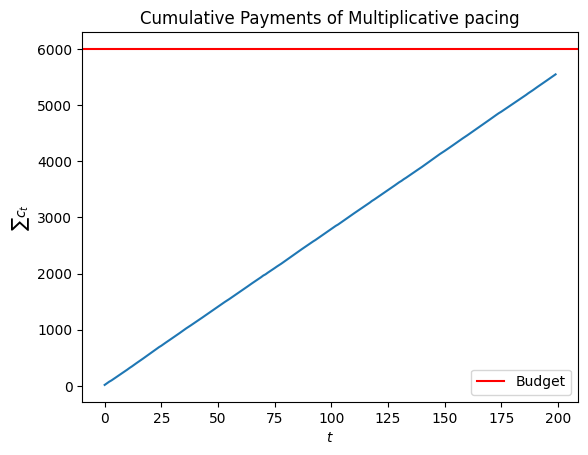

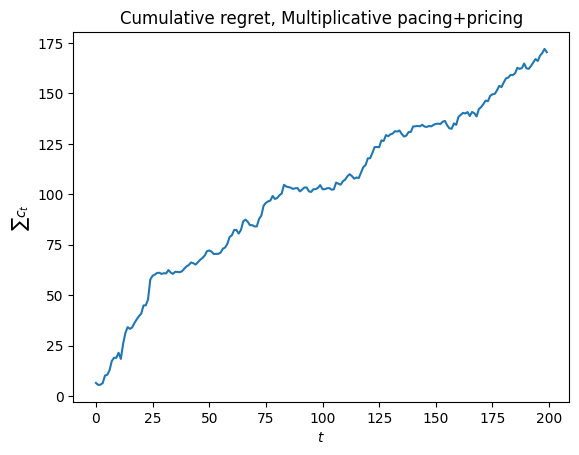

In [9]:
plt.plot(np.arange(days), cumtot_cost)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative pacing')
plt.show()
plt.plot(np.arange(days), clair_profits-profits)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.title('Cumulative regret, Multiplicative pacing+pricing')
plt.show()

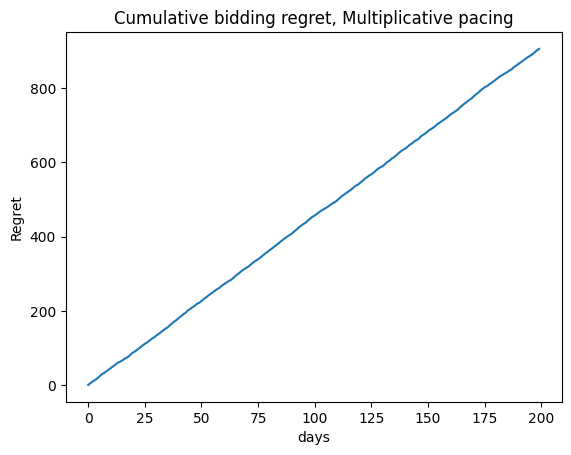

In [13]:
plt.plot(clair_utility-utility_log)
plt.xlabel('days')
plt.ylabel('Regret')
plt.title('Cumulative bidding regret, Multiplicative pacing')
plt.show()

We are bidding for many rounds, so there is a lot of variability between the agent (that bids more often) and the clairvoyant (that bids in rounds where m_t is lowest)

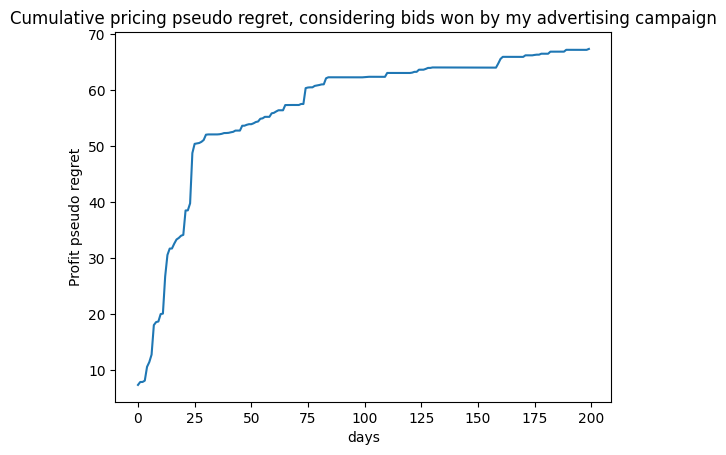

In [11]:
plt.plot(expected__pricing_pseudo_regret)
plt.xlabel('days')
plt.ylabel('Profit pseudo regret')
plt.title('Cumulative pricing pseudo regret, considering bids won by my advertising campaign')
plt.show()

In some days the curve seems flat because few bids were won

### This way we change bid value many times for the same price. Then each day we chamge the price p and we try with different prices

In [14]:
#parameters
days=200
n_users = 100
n_advertisers = 15 # four advertisers, including myself
ctrs = np.ones(n_advertisers)
B = 6000
my_valuation=0.75
profitcurve=lambda price,n_cust: n_cust*norm_dem_curve(price)*(price-cost)

#logging
profits=np.array([])
clair_profits=np.array([])
utility_log=np.zeros(days)
clair_utility=np.zeros(days)
pricing_profit=np.zeros(days)
expected__pricing_pseudo_regret=np.zeros(days)

cumtot_cost = np.array([])


# competitors
other_bids = np.clip(np.random.normal(0.4, 0.2, size = (n_advertisers-1, n_users*days)), 0, 1)
m_t = other_bids.max(axis=0)
## I'm considering competitors stronger than me, since they are free to exceed my budget

# In stochastic enviroment a greedy clairvoyant 
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users*days)

eta = 1/np.sqrt(n_users) # from theory

#agents,envs
bidding_agent = ucblike(B,n_users,1,my_valuation,range=0.1)
auction = SecondPriceAuction(ctrs)
pricing_env=PricingEnvironment(norm_dem_curve,cost)
pricing_agent=GPUCBAgent(n_users*days)
expected_max_profit=get_expected_profit(norm_dem_curve,cost,np.linspace(0,1,discretization))

for d in range(days):
    #choose price
    price=pricing_agent.pull_arm()
    #bids won in the day
    bids_won=0
    #cost of the day
    tot_cost=0
    #utility of the day
    utility=0
    for u in range(n_users):
        #choose bid
        my_bid = bidding_agent.bid()
        bids = np.append(my_bid, other_bids[:, u+d*n_users].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u+d*n_users])*my_win, m_t[u+d*n_users]*my_win
        bids_won+=my_win
        tot_cost+=c_t
        utility+=f_t
        #update bidding agent
        bidding_agent.update(f_t, c_t)
    utility_log[d]=utility
    cumtot_cost = np.append(cumtot_cost, tot_cost)
    
    #user buys with a probability that depends on the price
    if bids_won>0:
        d_t, r_t = pricing_env.round(price, bids_won)
        pricing_agent.update(r_t/bids_won)
    else: 
        r_t=0
    pricing_profit[d]=r_t
    profits=np.append(profits,r_t)
    #pseudo regret for pricing (considering bids won by my advertising campaign)
    expected__pricing_pseudo_regret[d]=(bids_won*expected_max_profit)-(profitcurve(price,bids_won))
    #calculate clairvoyant profit
    clair_num_daily=clairvoyant_payments[d*n_users:(d+1)*n_users]
    clair_num=np.count_nonzero(clair_num_daily)
    cd,cr=pricing_env.round(best_price,clair_num)
    clair_cumpay=np.sum(clair_num_daily)
    clair_profits=np.append(clair_profits,cr)
    clair_utility[d]=np.sum(clairvoyant_utilities[d*n_users:(d+1)*n_users])

profits=np.cumsum(profits)
cumtot_cost = np.cumsum(cumtot_cost)
clair_profits=np.cumsum(clair_profits)
utility_log=np.cumsum(utility_log)
clair_utility=np.cumsum(clair_utility)
pricing_profit=np.cumsum(pricing_profit)
expected__pricing_pseudo_regret=np.cumsum(expected__pricing_pseudo_regret)


KeyboardInterrupt: 

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\danie\AppData\Local\Temp\ipykernel_23972\372702805.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\danie\AppData\Local\Temp\ipykernel_23972\372702805.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')


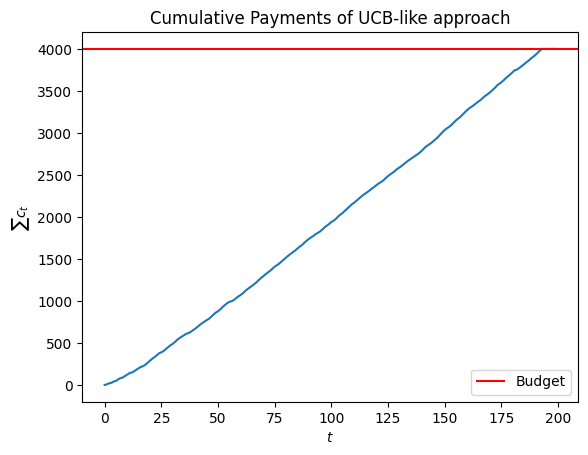

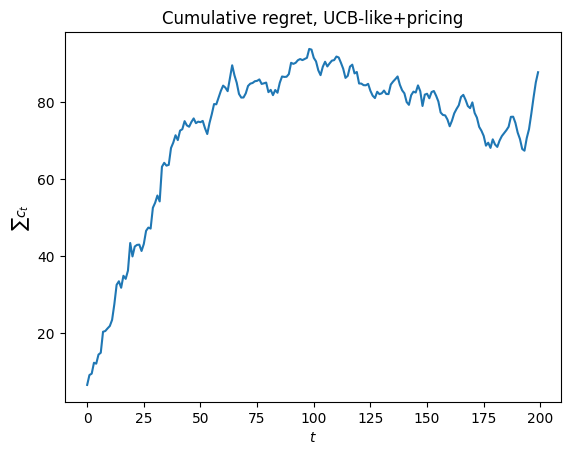

In [15]:
plt.plot(np.arange(days), cumtot_cost)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB-like approach')
plt.show()
plt.plot(np.arange(days), clair_profits-profits)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.title('Cumulative regret, UCB-like+pricing')
plt.show()

UCB-like approach depletes the budget much faster due to exploration of the different pssible bids

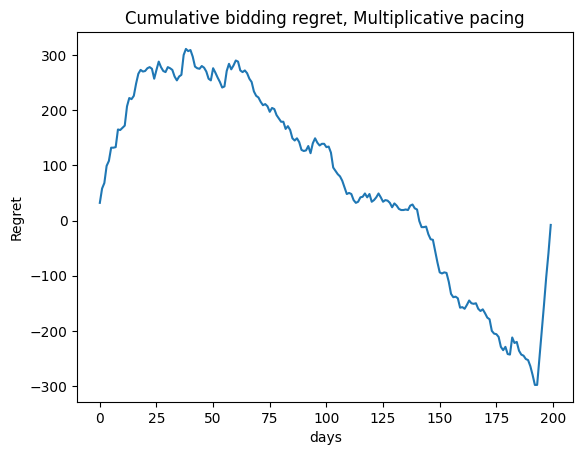

In [16]:
plt.plot(clair_utility-utility_log)
plt.xlabel('days')
plt.ylabel('Regret')
plt.title('Cumulative bidding regret, Multiplicative pacing')
plt.show()

Wins more auctions than the clairvoyant in the beginning, but depletes the budget faster doing so, and in the end the regret is of course linear

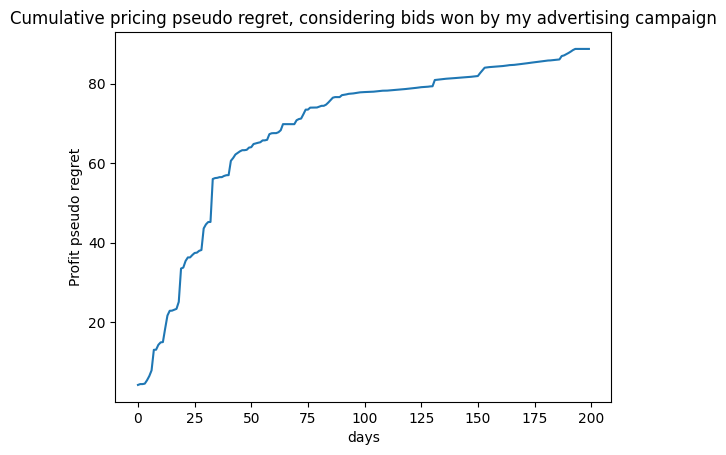

In [17]:
plt.plot(expected_pricing_pseudo_regret)
plt.xlabel('days')
plt.ylabel('Profit pseudo regret')
plt.title('Cumulative pricing pseudo regret, considering bids won by my advertising campaign')
plt.show()

After day 175 the curve is flat -> no more bids were won